In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from tqdm import tqdm_notebook as tqdm

In [137]:
mtest = pd.read_csv('/content/drive/MyDrive/BDM/metadata_test.csv',nrows=600)
mtrain= pd.read_csv('/content/drive/MyDrive/BDM/metadata_train.csv',nrows=1200)


In [138]:
len(mtrain)

1200

In [139]:
len(mtest)

600

In [140]:
# Load training data


v_raw_train = pq.read_pandas('/content/drive/MyDrive/BDM/train.parquet',columns=[str(i) for i in range(1200)]).to_pandas().values
meta_train = np.loadtxt('/content/drive/MyDrive/BDM/metadata_train.csv', skiprows=1, delimiter=',')
y_train = meta_train[:, 3].astype(bool)

print(v_raw_train.shape)

(800000, 1200)


In [141]:
y_train=y_train[:-7512]

In [142]:
len(y_train)

1200

In [143]:
len(meta_train)

8712

In [144]:
meta_train=meta_train[:-7512, :] #keeping to 1000 rows only

In [145]:
len(meta_train)

1200

In [146]:
def compute_spectra(v_raw, *, m = 1000):
    """
    compute mean and percentile - mean for every chunk of m data
    
    Args:
      v_raw (array): 800,000 x n_sample; the input
      m (int): the chunk size
    
    Returns: d (dict)
      d['mean']: mean in each chunks
      d['percentile']: percentile - mean
    """
    percentile = (100, 99, 95, 0, 1, 5)
    
    n = v_raw.shape[1] # number of samples
    length = v_raw.shape[0] // m # 800,000 -> 800
    n_spectra = len(percentile)
    
    mean_signal = np.zeros((n, length), dtype='float32') # mean in each chunk
    percentile_spectra = np.zeros((n, length, n_spectra), dtype='float32')
    
    # compute spectra
    print('computing spectra...', flush=True)
    for i in tqdm(range(n)):
        v = v_raw[:, i].astype('float32').reshape(-1, m) / 128.0
        
        mean = np.mean(v, axis=1)        
        s = np.abs(np.percentile(v, percentile, axis=1) - mean)
        
        # subtract baseline
        h = np.percentile(s, 5.0)
        s = np.maximum(0.0, s - h)

        mean_signal[i, :] = mean
        percentile_spectra[i, :, :] = s.T
            
    d = {}
    d['mean'] = mean_signal
    d['percentile'] = percentile_spectra
    
    return d

spec_train = compute_spectra(v_raw_train)
print('done.')

computing spectra...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1200 [00:00<?, ?it/s]

done.


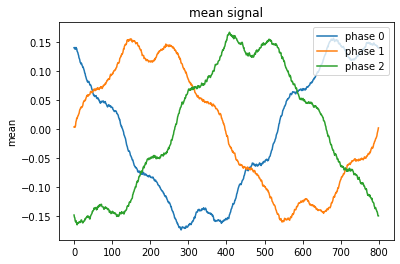

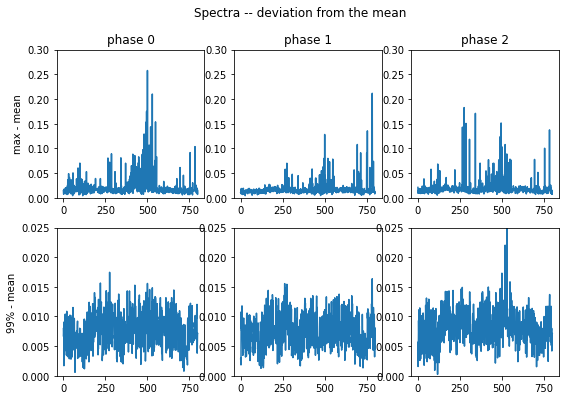

In [147]:
%matplotlib inline
import matplotlib.pyplot as plt

i_vis = 0

plt.title('mean signal')
plt.ylabel('mean')
        
for iphase in range(3):
    plt.plot(spec_train['mean'][i_vis + iphase, :], label='phase %d' % iphase)

plt.legend(loc=1)
plt.show()

#
# spectra
#
nrow = 2
ncol = 3
plt.figure(figsize=(3*ncol, 3*nrow))
plt.suptitle('Spectra -- deviation from the mean')

for icol in range(3):
    plt.subplot(nrow, ncol, icol + 1)
    plt.title('phase %d' % icol)
    plt.ylim(0, 0.3)
    
    if icol == 0:
        plt.ylabel('max - mean')
        
    # max
    plt.plot(spec_train['percentile'][i_vis + icol, :, 0])
    
    # 99% percentile
    plt.subplot(nrow, ncol, icol + ncol + 1)
    plt.ylim(0, 0.025)
    
    if icol == 0:
        plt.ylabel('99% - mean')
    plt.plot(spec_train['percentile'][i_vis + icol, :, 1])

In [148]:

import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() 

In [149]:


def max_windowed(spec, *, width=150, stride=10):
    """
    Smooth the spectrum with a tophat window function and find the
    peak inteval that maximises the smoothed spectrum.
    
    Returns: d(dict)
      d['w'] (array): smoothed max - mean spectrum
      d['ibegin'] (array): the left edge index of the peak interval
    """
    n = spec.shape[0]
    length = spec.shape[1] # 800
    nspec = spec.shape[2] # 6 spectra

    n_triplet = n // 3

    # Reorganize the max spectrum from 8712 data to 2904 triplets with 3 phases
    max_spec3 = np.empty((n_triplet, length, 3))
    for i_triplet in range(n_triplet):
        max_spec3[i_triplet, :, 0] = spec[3*i_triplet, :, 0] # phase 0
        max_spec3[i_triplet, :, 1] = spec[3*i_triplet + 1, :, 0] # phase 1
        max_spec3[i_triplet, :, 2] = spec[3*i_triplet + 2, :, 0] # phase 2

    x = tf.placeholder(tf.float32, [None, length, 3]) # input spectra before smoothing
    # 800 -> 80: static convolaution
    # convolution but not CNN, the kernel is static
    # smoothing/convolution kernel
    # tophat window function
    # shape (3, 1) adds up 3 phases to one output
    K = np.ones((width, 3, 1), dtype='float32') / width

    W_conv1 = tf.constant(K)
    h_conv1 = tf.nn.conv1d(x, W_conv1, stride=stride, padding='VALID')
    
    with tf.Session() as sess:
        w = sess.run(h_conv1, feed_dict={x:max_spec3})

    imax = np.argmax(w[:, :, 0], axis=1) # index of maximum smoothed spectrum
    
    d = {}
    d['w'] = w # smoothed max spectrum
    d['ibegin'] = imax*stride
    
    return d

peaks = max_windowed(spec_train['percentile'])

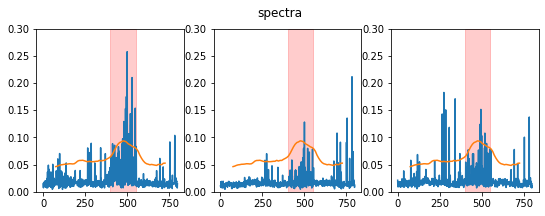

In [150]:
i_vis = 0
nrow = 1
ncol = 3
plt.figure(figsize=(3*ncol, 3*nrow))
plt.suptitle('spectra')

for j in range(3):
    plt.subplot(nrow, ncol, j + 1)
    plt.ylim(0, 0.3)
    
    ibegin = peaks['ibegin'][i_vis]
    plt.axvspan(ibegin, ibegin + 150, alpha=0.2, color='red')
    
    # max - mean spectrum
    plt.plot(spec_train['percentile'][i_vis + j, :, 0])
    
    # smoothed max - mean spectrum
    xx = np.arange(peaks['w'].shape[1])*10 + 150//2
    plt.plot(xx, peaks['w'][i_vis])

In [151]:
def compute_features(v_raw, spec=None):
    """
    Args:
      v_raw (array): The original 800,000 x 1200 training data
      spec (dict): The result of compute_spectra() if already computed.
                   If it is None, it will be computed automatically.
    
    Returns:
       X (array): Feature vector of shape (400, 57)
                  400 triplets, 57 features
    """
    if spec is None:
        spec = compute_spectra(v_raw)
    
    v_spec = spec['percentile']
    shape = v_spec.shape
    n = shape[0] # number of data
    length = shape[1]
    nspec = shape[2]
    
    n_triplet = n // 3
    
    # Reorder to i_triplet, phase
    spec3 = np.empty((n_triplet, length, nspec, 3))
    
    for i_triplet in range(n_triplet):
        spec3[i_triplet, :, :, 0] = v_spec[3*i_triplet, :, :] # phase 0
        spec3[i_triplet, :, :, 1] = v_spec[3*i_triplet + 1, :, :] # phase 1
        spec3[i_triplet, :, :, 2] = v_spec[3*i_triplet + 2, :, :] # phase 2

    # extract "max-windowed" from the spectra
    width = 150
    peaks = max_windowed(v_spec, width=width)
    
    # Feature vector
    n_feature4 = 3
    X = np.empty((n_triplet, n_feature4*nspec*3 + 3))
    
    # features for each percentile and phase
    X4 = np.empty((n_triplet, n_feature4, nspec, 3)) # triplet, figure, spec type, phase
        
    for i_triplet in range(n_triplet):       
        # Maximum of the spectra in the full range
        # 18 features (6 percentiles x 3 phases)
        X4[i_triplet, 0, :, :] = np.max(spec3[i_triplet, :, :, :], axis=0)
        
        # Peak interval
        ibegin = peaks['ibegin'][i_triplet]
        iend = ibegin + width
        imid = ibegin + width // 2
    
        # Mean of the spectra in the peak inteval 18 features
        X4[i_triplet, 1, :, :] = np.mean(spec3[i_triplet, ibegin:iend, :, :], axis=0)
        
        # Max of the spectra in the peak inteval (18 features)
        X4[i_triplet, 2, :, :] = np.max(spec3[i_triplet, ibegin:iend, :, :], axis=0)
        
        # Mean signal at the midpoint of the interval (3 features)
        X[i_triplet, 0] = spec['mean'][3*i_triplet,     imid]
        X[i_triplet, 1] = spec['mean'][3*i_triplet + 1, imid]
        X[i_triplet, 2] = spec['mean'][3*i_triplet + 2, imid]
    
    shape = X4.shape
    
    # Flatten the X4 tensor
    # 3 + 18x3 = 57 features
    X[:, 3:] = X4.reshape(shape[0], shape[1]*shape[2]*shape[3])
    
    return X

X_all3 = compute_features(v_raw_train, spec_train)

# The label for the triple
# True iff two or more labels in 3 phases are True
y_all3 = np.sum(y_train.reshape(-1, 3), axis=1) >= 2

print('Three phases are combined into one training data; the shapes are, therefore,')
print(X_all3.shape, y_all3.shape)

Three phases are combined into one training data; the shapes are, therefore,
(400, 57) (400,)


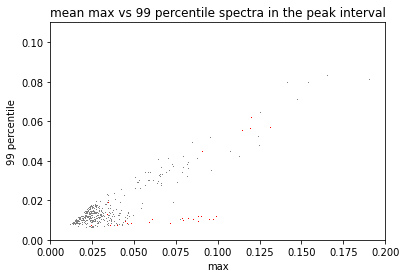

In [152]:
plt.figure()
plt.title('mean max vs 99 percentile spectra in the peak interval')
plt.xlabel('max')
plt.ylabel('99 percentile')
plt.ylim(0, 0.11)
plt.xlim(0, 0.2)


j_max = 3 + 18 + 0
j_99 = 3 + 18 + 3

idx_pos = y_all3 # positive samples
idx_neg = np.logical_not(y_all3) # negative samples

plt.plot(X_all3[idx_neg, j_max], X_all3[idx_neg, j_99], ',', color='gray', label='False')
plt.plot(X_all3[idx_pos, j_max], X_all3[idx_pos, j_99], ',', color='red', label='True')
plt.show()

ignore


In [153]:
knowledge_data = pd.read_csv('/content/drive/MyDrive/BDM/sub_ens_v16.csv')

In [154]:
len(knowledge_data)

20337

In [155]:
knowledge_data.head(2)

,signal_id,target
0,8712,0
1,8713,0


In [156]:
knowledge_data.count()

signal_id    20337
target       20337
dtype: int64

began


In [157]:
# Release RAM of the training data 
if 'v_raw_train' in globals():
    del v_raw_train

# Load test data
id_test = np.loadtxt('/content/drive/MyDrive/BDM/metadata_test.csv', skiprows=1, delimiter=',')[:, 0].astype(int)
id_test=id_test[:600]
n_test = len(id_test)

X_tests = []

# Load test data and compute the feature vector
# The test data is split into 4 to fit it into RAM
n_subset = 4
nread = 0

for i_subset in range(n_subset):
    # signal_id range in the test data; 8712 is the first data in the test.parquet
    ibegin = 8712 + 3*int(n_test // 3 * (i_subset/n_subset))
    iend = 8712 + 3*int(n_test // 3 * ((i_subset + 1)/n_subset))
    
    print('Loading %d/%d; signal_id %d - %d...' % (i_subset, n_subset, ibegin, iend))
    v_raw_test = pq.read_pandas('/content/drive/MyDrive/BDM/test.parquet',columns=[str(i) for i in range(ibegin, iend)]).to_pandas().values
    
    nread += v_raw_test.shape[1]
    X = compute_features(v_raw_test)
    X_tests.append(X)
    print('%d/%d test data processed.' % (nread, n_test))

    del v_raw_test

X_test = np.concatenate(X_tests, axis=0)
assert(X_test.shape[0] == id_test.shape[0] // 3)

del X_tests

print('X_test computation done. shape', X_test.shape)

Loading 0/4; signal_id 8712 - 8862...
computing spectra...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/150 [00:00<?, ?it/s]

150/600 test data processed.
Loading 1/4; signal_id 8862 - 9012...
computing spectra...


  0%|          | 0/150 [00:00<?, ?it/s]

300/600 test data processed.
Loading 2/4; signal_id 9012 - 9162...
computing spectra...


  0%|          | 0/150 [00:00<?, ?it/s]

450/600 test data processed.
Loading 3/4; signal_id 9162 - 9312...
computing spectra...


  0%|          | 0/150 [00:00<?, ?it/s]

600/600 test data processed.
X_test computation done. shape (200, 57)


In [158]:
len_train=len(X_all3)

y_list=knowledge_data['target'].values
y_test=[]
for j in range(0,len(y_list),3):
    y_test.append(y_list[j])
y_test=np.asarray(y_test)
del knowledge_data
# gc.collect()
print(X_all3.shape,y_all3.shape)
y_test=y_test[:200]
print(X_test.shape,y_test.shape)
#
X_all3=np.concatenate([X_all3,X_test])
y_all3=np.concatenate([y_all3,y_test]) 

(400, 57) (400,)
(200, 57) (200,)


In [133]:
y_test.shape

(6779,)

In [160]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [161]:
import sklearn.model_selection
import sklearn.metrics

from catboost import CatBoostClassifier

# split into train and CV data
n_splits = 5

models = []
scores = np.zeros(n_splits)

print('Training...')
print('MCC training & cv') # MCC = Matthews Correlation Coefficient


seeds=[0,42,1204,2019]
for seed in seeds:
    splits = list(sklearn.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed).split(X_all3, y_all3))

    for i, (idx_train, idx_cv) in enumerate(splits):
        X_train = X_all3[idx_train, :]
        y_train = y_all3[idx_train]

        X_cv = X_all3[idx_cv, :]
        y_cv = y_all3[idx_cv]

        # Learning rate is important; large values overfit the data
        learning_rate = 0.006
        model = CatBoostClassifier(learning_rate=learning_rate, od_type='IncToDec',
                                loss_function='Logloss', use_best_model=True, eval_metric='MCC')

        model.fit(X_train, y_train.astype(float), silent=True,
                  eval_set=(X_cv, y_cv.astype(float)))

        y_predict_train = model.predict(X_train)
        y_predict_cv = model.predict(X_cv)

    #     score_train = sklearn.metrics.matthews_corrcoef(y_train, y_predict_train)
        score_cv = sklearn.metrics.matthews_corrcoef(y_cv, y_predict_cv)

        models.append(model)
        scores[i] = score_cv
    
#     print('%d %.3f %.3f' % (i, score_train, score_cv))

print('CV scores %.3f ± %.3f' % (np.mean(scores), np.std(scores)))

Training...
MCC training & cv
CV scores 0.652 ± 0.128
